In [1]:
import torch
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.multi_objective import qExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective import pareto
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt


In [2]:
import DTLZ2_model
import fischer_model
from botorch.test_functions.multi_objective import DTLZ2
from DTLZ2_model import neg_l1_dist
from DTLZ2_model import predict_DTLZ2_model
from fischer_model import predict_fischer_model
import torch
import numpy as np
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
dim = 4
N = 100
MC_SAMPLES = 128
NUM_RESTARTS = 10
RAW_SAMPLES = 512

BATCH_SIZE = 5
iteration_number = 10
#bounds of the inputs
bounds = torch.stack([torch.zeros(dim), torch.ones(dim)]).to(device=device, dtype=dtype)
refi = torch.tensor([0., 0. ,0. , 0.], device=device, dtype=dtype)

In [4]:
# train_x = torch.rand(100, 4, dtype=torch.float32)
train_x = draw_sobol_samples(bounds=bounds, n=1, q=N).squeeze(0).to(device=device, dtype=dtype)
train_y = predict_fischer_model(train_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [5]:
train_x, train_y

(tensor([[0.4529, 0.0925, 0.6269, 0.8092],
         [0.9727, 0.4681, 0.8910, 0.3091],
         [0.9750, 0.5290, 0.6868, 0.6830],
         [0.9354, 0.2233, 0.4723, 0.5676],
         [0.3324, 0.2721, 0.4717, 0.9259],
         [0.0493, 0.7957, 0.5245, 0.5649],
         [0.9612, 0.2672, 0.0248, 0.7007],
         [0.9482, 0.7301, 0.8332, 0.6073],
         [0.7056, 0.9108, 0.0602, 0.3730],
         [0.8478, 0.8025, 0.1331, 0.4022],
         [0.9319, 0.7384, 0.3557, 0.6872],
         [0.3788, 0.5722, 0.9357, 0.6278],
         [0.5915, 0.3983, 0.7661, 0.1436],
         [0.7899, 0.5256, 0.3801, 0.8231],
         [0.2700, 0.9704, 0.8112, 0.3645],
         [0.5916, 0.4689, 0.1106, 0.4503],
         [0.9316, 0.6487, 0.9456, 0.5642],
         [0.9273, 0.7443, 0.2646, 0.1305],
         [0.8845, 0.9308, 0.1127, 0.0787],
         [0.7535, 0.7333, 0.5758, 0.4214],
         [0.7766, 0.6872, 0.3372, 0.7365],
         [0.9611, 0.5567, 0.0897, 0.8421],
         [0.4467, 0.6512, 0.5946, 0.9976],
         [0

In [6]:
# # Initialize models for each objective
# models = [SingleTaskGP(train_X=train_x, train_Y=train_y[:, i].unsqueeze(-1)) for i in range(train_y.shape[-1])]

# # Fit models
# mlls = [ExactMarginalLogLikelihood(model.likelihood, model) for model in models]
# for mll in mlls:
#     fit_gpytorch_model(mll)

# # Combine models into a ModelListGP
# model = ModelListGP(*models)

In [7]:
model = SingleTaskGP(train_X=train_x, train_Y=train_y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [8]:
#condition for the pareto front
partitioning = FastNondominatedPartitioning(
    ref_point=refi,
    Y=train_y,
    )

In [11]:
for i in range(iteration_number):
    print("Iteration: "+str(i))
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=refi,
        partitioning=partitioning,
        #sampler=qehvi_sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = candidates.detach()
    new_y = predict_fischer_model(new_x)

    train_x=torch.vstack([train_x,new_x])
    train_y=torch.vstack([train_y,new_y])

    models = [SingleTaskGP(train_X=train_x, train_Y=train_y[:, i].unsqueeze(-1)) for i in range(train_y.shape[-1])]

 # Fit models
    mlls = [ExactMarginalLogLikelihood(model.likelihood, model) for model in models]
    for mll in mlls:
        fit_gpytorch_model(mll)
    model = ModelListGP(*models)

    partitioning = FastNondominatedPartitioning(
        ref_point=refi,
        Y=train_y,
        )

Iteration: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Iteration: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Iteration: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Iteration: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Iteration: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Iteration: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


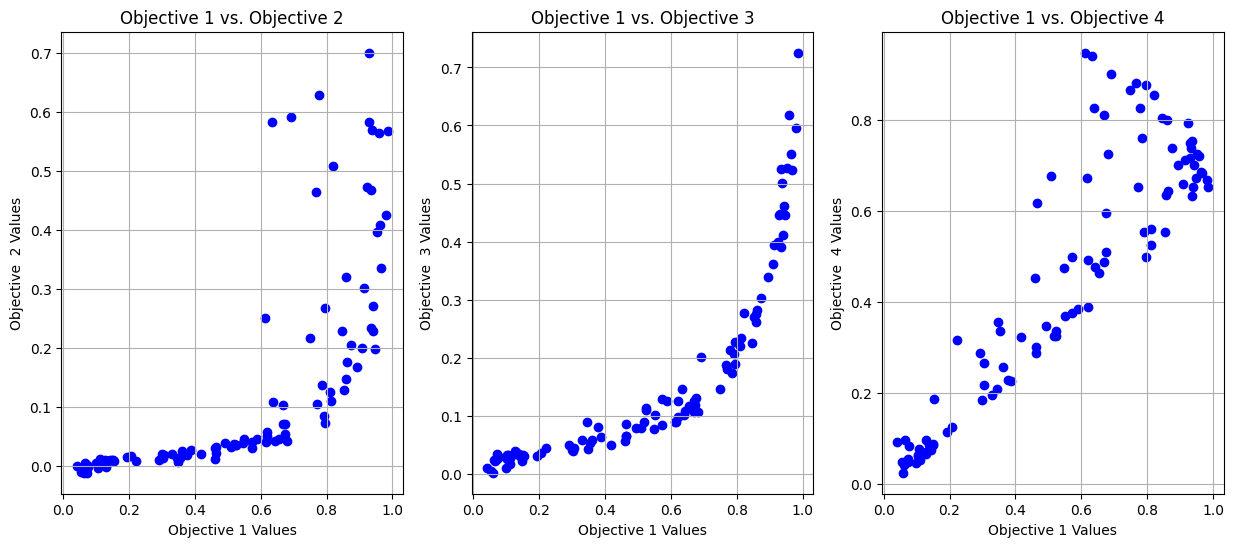

In [54]:
plt.figure(figsize=(15, 6))
n = [1,2,3]
count = 0
for i in n:
    count +=1
    plt.subplot(1,3,count)
    plt.scatter(train_y[:, 0].cpu().numpy(), train_y[:, i].cpu().numpy(), color='blue')
    plt.title('Objective 1 vs. Objective %s'%(i+1))
    plt.xlabel('Objective 1 Values')
    plt.ylabel('Objective  %s Values'%(i+1))
    plt.grid(True)
plt.show()

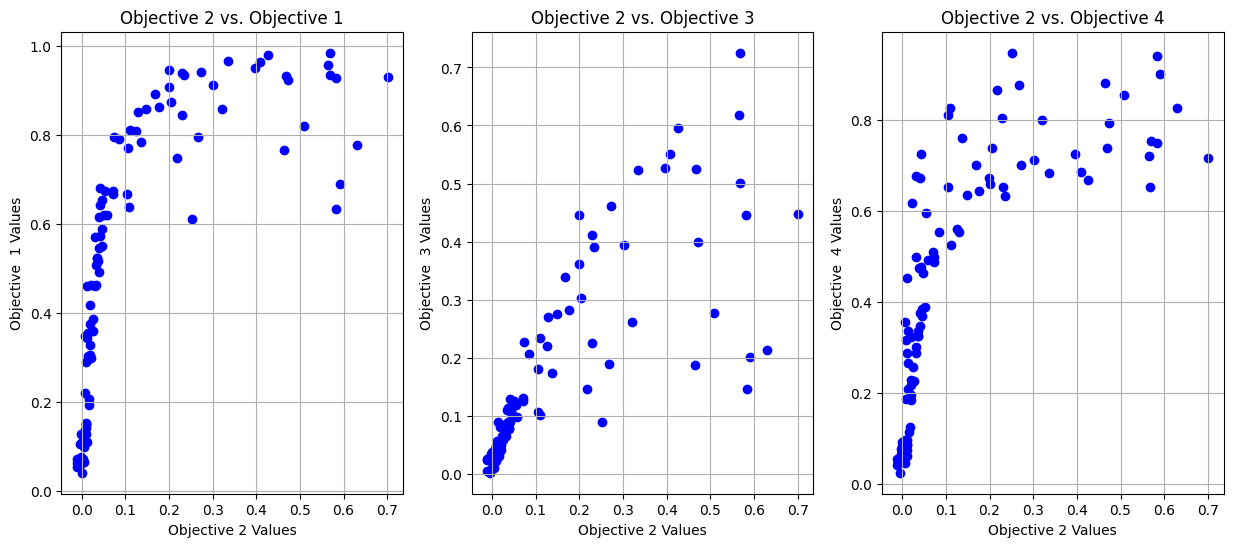

In [50]:
plt.figure(figsize=(15, 6))
n = [0,2,3]
count = 0
for i in n:
    count +=1
    plt.subplot(1,3,count)
    plt.scatter(train_y[:, 1].cpu().numpy(), train_y[:, i].cpu().numpy(), color='blue')
    plt.title('Objective 2 vs. Objective %s'%(i+1))
    plt.xlabel('Objective 2 Values')
    plt.ylabel('Objective  %s Values'%(i+1))
    plt.grid(True)
plt.show()

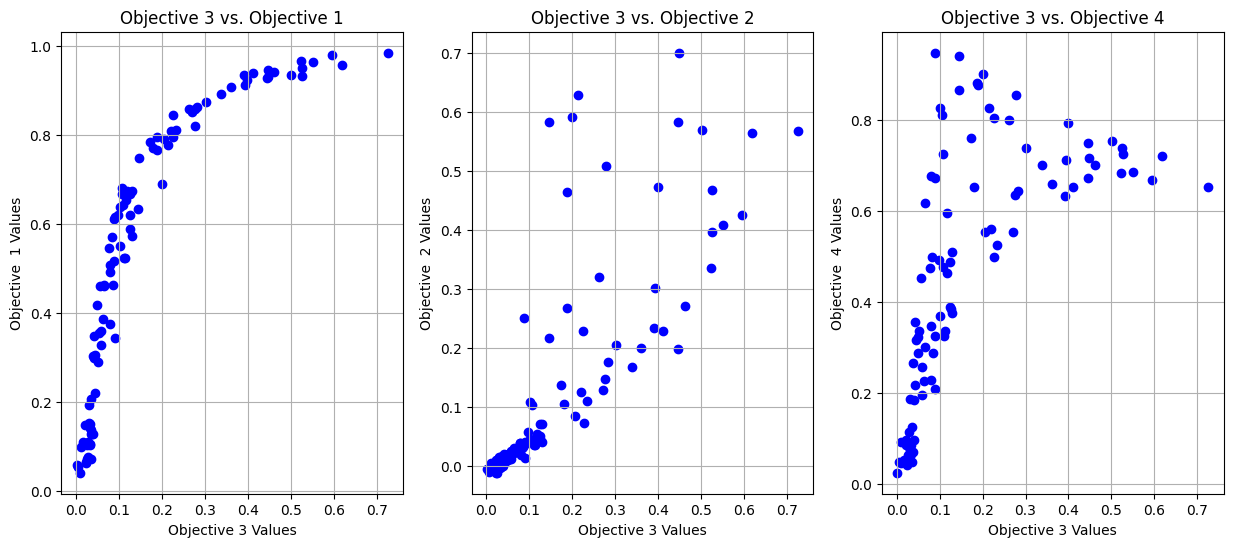

In [56]:
plt.figure(figsize=(15, 6))
n = [0,1,3]
count = 0
for i in n:
    count +=1
    plt.subplot(1,3,count)
    plt.scatter(train_y[:, 2].cpu().numpy(), train_y[:, i].cpu().numpy(), color='blue')
    plt.title('Objective 3 vs. Objective %s'%(i+1))
    plt.xlabel('Objective 3 Values')
    plt.ylabel('Objective  %s Values'%(i+1))
    plt.grid(True)
plt.show()

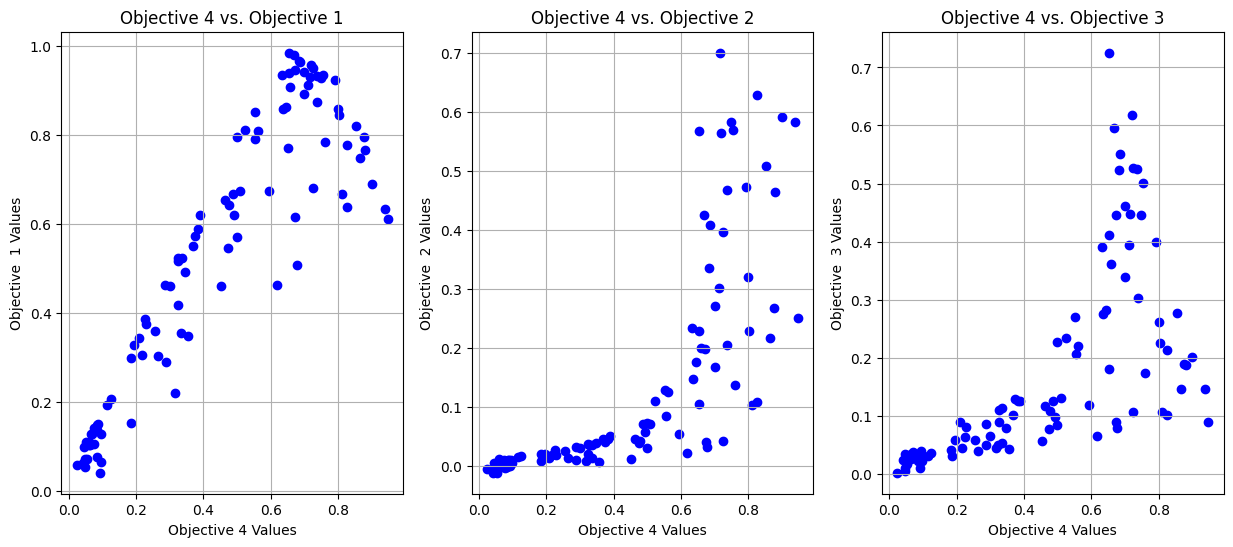

In [57]:
plt.figure(figsize=(15, 6))
n = [0,1,2]
count = 0
for i in n:
    count +=1
    plt.subplot(1,3,count)
    plt.scatter(train_y[:, 3].cpu().numpy(), train_y[:, i].cpu().numpy(), color='blue')
    plt.title('Objective 4 vs. Objective %s'%(i+1))
    plt.xlabel('Objective 4 Values')
    plt.ylabel('Objective  %s Values'%(i+1))
    plt.grid(True)
plt.show()